In [12]:
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import pad

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods

torch.Size([1, 1, 99, 99])


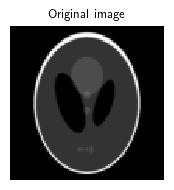

In [111]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

# Set up the variable to fetch dataset and operators.
in_shape = 99
out_shape = 169
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=in_shape, grayscale=True, resize_mode="resize", device=device
)

print(x.shape)
plot(x, titles="Original image")

In [112]:
# We use the original image as the phase information for the complex signal.
# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi)

# For phase retrieval, the signal should be complex-valued.
print(x_phase.dtype)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

torch.complex64


In [113]:
physics = dinv.physics.PseudoRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1,in_shape,in_shape),
    output_shape=(1,out_shape,out_shape),
    #noise_model=dinv.physics.GaussianNoise(sigma=0.05),
)
oversampling = out_shape**2/(in_shape**2)
y = physics(x_phase)

In [114]:
# make sure the linear operator is unitary
torch.allclose(physics.B_adjoint(physics.B(x_phase)), x_phase, atol=1e-6)

True

In [115]:
def iid_optimal(y, physics):
    return torch.max(1 - 1 / y, torch.tensor(-5.0))

def identity(y, physics):
    return y

def unitary_first(y, physics):
    return 1 - torch.exp(-physics.oversampling_ratio*y/4)

def unitary_second(y, physics):
    return (physics.oversampling_ratio*y) / (physics.oversampling_ratio*y + torch.sqrt(physics.oversampling_ratio - 1))

def unitary_third(y, physics):
    return (physics.oversampling_ratio*y) / (physics.oversampling_ratio*y + 1)

In [116]:
x_phase.norm()

tensor(99.)

In [117]:
preprocessing = iid_optimal

x_spec = spectral_methods(y, physics, preprocessing=preprocessing, n_iter=2500)
print(cosine_similarity(x_spec*torch.sqrt(y.sum()), x_phase))
print(cosine_similarity(x_spec,x_phase))

diag_T = preprocessing(y / torch.mean(y), physics)
diag_T = diag_T.to(torch.cfloat)
res = physics.B(x_spec)
res = diag_T * res
res = physics.B_adjoint(res)

res / x_spec

tensor(0.7430)
tensor(0.7430)


tensor([[[[0.3561-5.6679e-05j, 0.3562+2.0858e-05j, 0.3561-2.3256e-05j,
            ..., 0.3561-2.8819e-05j, 0.3561-1.6274e-05j,
           0.3561+1.6215e-05j],
          [0.3561+6.5704e-06j, 0.3561-2.5125e-05j, 0.3561+2.6744e-05j,
            ..., 0.3561-6.7003e-05j, 0.3561-2.6771e-05j,
           0.3561+3.4116e-05j],
          [0.3563+1.3314e-04j, 0.3561+1.8451e-06j, 0.3561-1.8594e-05j,
            ..., 0.3561+4.7249e-05j, 0.3565+1.3640e-04j,
           0.3561+5.5478e-06j],
          ...,
          [0.3560+8.2889e-06j, 0.3561-9.3285e-05j, 0.3558-3.1881e-04j,
            ..., 0.3561-3.3918e-05j, 0.3560-1.2252e-04j,
           0.3561-1.9793e-05j],
          [0.3561+1.8713e-05j, 0.3561-1.2395e-05j, 0.3561-2.0335e-05j,
            ..., 0.3561+7.8500e-06j, 0.3561+1.0744e-05j,
           0.3560+3.3818e-05j],
          [0.3562+3.8429e-05j, 0.3561-5.5857e-05j, 0.3561+3.0774e-05j,
            ..., 0.3561-1.3073e-05j, 0.3562-2.6264e-05j,
           0.3560+8.1924e-05j]]]])

In [118]:
def run_gd(
        y,
        physics,
        oversampling,
        device,
        dtype = torch.cfloat,
        num_iter = 1500,
        stepsize = 0.005,
        data_fidelity = dinv.optim.L2(),
        init = "random",
        spec_iter = 300,
):
    stepsize = stepsize * oversampling

    if init == "random":
        x_gd = torch.randn((y.shape[0],) + physics.img_shape).to(device)
    elif init == "spectral":
        x_gd = spectral_methods(y, physics, n_iter=spec_iter)
    else:
        raise ValueError("init should be either 'random' or 'spectral'")

    for _ in range(num_iter):
        x_gd = x_gd - stepsize * data_fidelity.grad(x_gd, y, physics)
    
    return x_gd

In [78]:
# # run a gradient descent algorithm to recover the original image

# loss_fn = dinv.optim.L2()
# iterator = dinv.optim.optim_iterators.GDIteration()
# OPTIM_PARAMS = {"stepsize": 0.07, "lambda": 1.0, "g_param": []}
# NUM_ITER = 4000

# # initial guess
# # x_est = torch.randn_like(x_phase)

# # spectral methods guess
# x_est = spectral_methods(y, physics,preprocessing=preprocessing,n_iter=2500)
# print(x.shape)

# loss_hist = []

# for _ in range(NUM_ITER):
#     loss_hist.append(loss_fn(x_est, y, physics))
#     res = iterator({"est": (x_est,), "cost": 0},
#         cur_data_fidelity=loss_fn,
#         cur_prior=dinv.optim.Zero(),
#         cur_params=OPTIM_PARAMS,
#         y=y,
#         physics=physics)
#     x_est = res["est"][0]

# print("loss_init:",loss_hist[0])
# print("loss_final:",loss_hist[-1])
# plt.plot(loss_hist)
# plt.yscale('log')
# plt.title('loss curve without spectral')
# plt.show()

In [122]:
x_est = run_gd(y,
               physics,
               oversampling,
               device='cpu',
               num_iter=10000,
               init='random',
               spec_iter=2500,
               stepsize=0.02)

cosine similarity tensor(0.0075)
Image 0, channel 0 does not have a global phase shift.


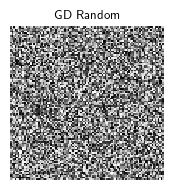

In [123]:
print("cosine similarity", cosine_similarity(x_est, x_phase))
# correct possible global phase shifts
x_est = correct_global_phase(x_est, x_phase)
# now no global phase shift should exist
# assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_recon = torch.angle(x_est) / (2*torch.pi) + 0.5
# assert torch.allclose(x_recon, x, rtol=1e-5)
plot(x_recon,titles="GD Random")

cosine similarity tensor(0.7430)
Image 0, channel 0 does not have a global phase shift.


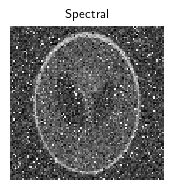

In [121]:
print("cosine similarity", cosine_similarity(x_spec, x_phase))
# correct possible global phase shifts
x_spec = correct_global_phase(x_spec, x_phase)
# now no global phase shift should exist
# assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_recon = torch.angle(x_spec) / (2*torch.pi) + 0.5
# assert torch.allclose(x_recon, x, rtol=1e-5)
plot(x_recon,titles="Spectral")